In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
label_size = 13
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = label_size


rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}

label_dict = {'wt': 'Wild type architecture', 'ltr': 'LTRs removed', 'ars': 'ARS removed', 'all': 'LTR and ARS removed', 'lauer': 'Lauer'}

<Axes: xlabel='Generation', ylabel='CNV Shannon diversity'>

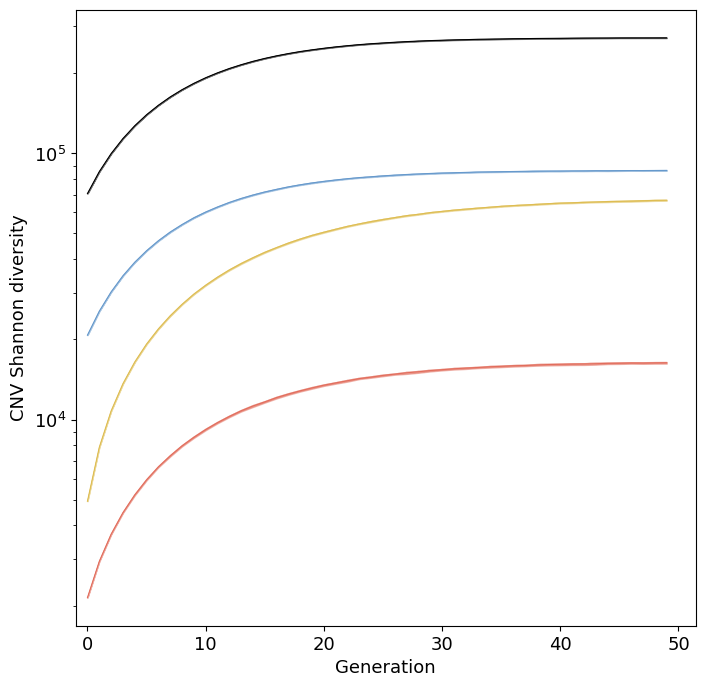

In [2]:
# Diversity
from diversity import simpleWF
from seaborn import histplot as hst

def calc_c1_c2_prob(ax,s_cnv,m_cnv,p_0,max_possible, color, plot = True, max_gen = 116):
    N=3.3e8
    generation = pd.read_csv(f'Chuong_116_gens.txt', delimiter = ', ', engine='python').columns.astype('int')
    Q,P = simpleWF(N, generation, s_cnv, m_cnv, p_0, max_possible)
    Q,P = Q[:max_gen+2], P[:max_gen+2]
    Q,P = Q[Q>1], P[Q>1] # Only count generations with at least one whole new CNV cell
    X = P.sum()
    tot_P = 0
    dist_list = []
    for t in range(len(Q)):
        tot_P += (P[t]**2/Q[t])/X**2
        dist_list = dist_list + [P[t]/Q[t] for i in range(int(Q[t]))]
    
    if plot:
        hst(dist_list, stat='count', bins=15, ax=ax, color=color)
        ax.set_xlabel('Number of different ancestors in group')
        ax.set_ylabel('Number of groups')
        ax.set_yscale('log')
    return tot_P, Q, P

# Plot Shannon for all lines
def plot_shannon_diversity(ax, line, s,m,p0, legend, linewidth):
    plot_shannon = []
    for j in range(50):
        tot_p, Q, P = calc_c1_c2_prob(ax,s,m,p0, np.inf, color='k', plot=False, max_gen=j)
        shannon = 0
        for i in range(len(Q)):
            p = max(1e-12,(P[i]/Q[i])/P.sum()) # Proportion of each CNV population
            shannon -= Q[i]*p*np.log(p) # Q[i] populations with the same proportion
        plot_shannon.append(np.exp(shannon))
        
    if legend:
        ax.plot(plot_shannon, color=rep_colors[line], label=label_dict[line], linewidth=linewidth)
        ax.legend(fontsize=12)
    else:
        ax.plot(plot_shannon, color=rep_colors[line], linewidth=linewidth)
    
    return plot_shannon

def plot_all_shannons(ax, lines):
    collective_maps = pd.read_csv('maps/collective_maps.csv', index_col=0)   
    collective_samples = pd.read_csv('maps/collective_posterior_samples.csv', index_col=0)
    diversity_df = pd.read_csv('maps/collective_diversities.csv', index_col=0)
    for line in lines:
        d = diversity_df[diversity_df['line']==line].iloc[:,1:]
        x = np.array(d.columns.tolist())
        d_25, d_75 = d.quantile(0.25), d.quantile(0.75)
        ax.plot(x, d_25, linewidth=0.1, color=rep_colors[line])
        ax.plot(x, d_75, linewidth=0.1, color=rep_colors[line])
        ax.fill_between(x,d_25,d_75, color= rep_colors[line], alpha=0.5)
        ax.plot(x, d.mean(), color= rep_colors[line], linewidth=0.8, label=label_dict[line])

    ax.set_yscale('log')
    ax.set_ylabel('CNV Shannon diversity')
    ax.set_xlabel('Generation')
    ax.set_xticks([10*i for i in range(6)])
    ax.set_xticklabels([10*i for i in range(6)])
    ax.set_xlim(-1)
    return ax
fig, ax = plt.subplots(figsize=(8,8))
chuong_lines = ['wt','ltr','ars','all']
plot_all_shannons(ax, chuong_lines)

/tmp/ipykernel_2828446/1298614325.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_params = torch.tensor(collective_maps.loc[line, 'log(s_cnv)':]) # sbi params
/tmp/ipykernel_2828446/1298614325.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_params = torch.tensor(collective_maps.loc[line, 'log(s_cnv)':]) # sbi params
/tmp/ipykernel_2828446/1298614325.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_

<Axes: xlabel='Generation', ylabel='Reported CNV proportion'>

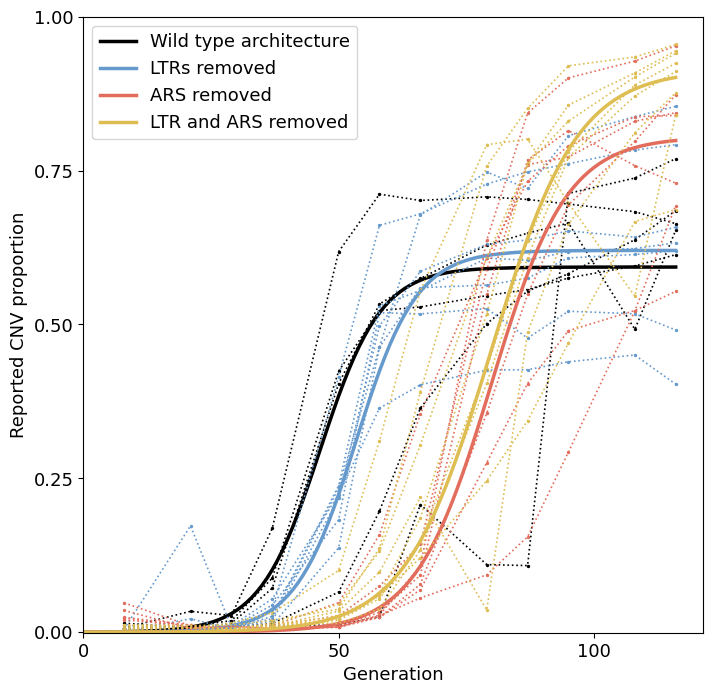

In [3]:
# Posterior Predictions
import torch
import sbi.utils as utils
import pickle
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF

# Preparations: posterior to use
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))

# Read desired data
def read_empirical(line, clean = False):
    if clean:
        obs = pd.read_csv(f'empirical_data/clean/{line}.csv', index_col=0)
    else:
        obs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0)
    return obs

all_maps_sbi = pd.read_csv('maps/sbi_all_maps_chuong.csv', index_col=0)

collective_maps = pd.read_csv('maps/collective_maps.csv', index_col=0)
collective_samples = pd.read_csv('maps/collective_posterior_samples.csv', index_col=0)

# Simulation & model parameters
reps = 1
chuong_generation = pd.read_csv(f'Chuong_116_gens.txt', delimiter = ', ', engine='python')
chuong_generation = chuong_generation.columns.astype('int')
N = 3.3e8

# Simulator function - generates a posterior prediction given model parameters
def CNVsimulator(cnv_params, generation):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
        
    return states


def posterior_predictions_main(ax, posterior, maps, lines, n_samples=0):
    
    for l in range(len(lines)):
        line = lines[l]
        # fig.suptitle(f'{label_dict[line]}')
        n = len(read_empirical(line))
        for i in range(n):
            axx = ax
            color = rep_colors[line]
            x = read_empirical(line,clean=False).iloc[i,:]
            generation = chuong_generation
            emp_x = read_empirical(line,clean=False).iloc[i,:]
            x = read_empirical(line,clean=False).iloc[i,:]
            axx.plot(generation, emp_x, color = color, linewidth=1.2, linestyle='dotted') # data points are plotted
            axx.scatter(generation, emp_x, color = color, s=2) # data points are scattered

            axx.set_ylabel(f'Reported CNV proportion')
            axx.set_xlabel(f'Generation')
            axx.set_ylim(-0.001)
            axx.set_xlim(-0.001)
            axx.set_yticks([0,0.25,0.5,0.75,1])
            axx.set_xticks([0,50,100])

        # Collective MAP
        axx = ax
        full_gen = np.array([i for i in range(117)])
        single_params = torch.tensor(collective_maps.loc[line, 'log(s_cnv)':]) # sbi params
        pred = CNVsimulator(single_params, generation=full_gen).T
        axx.plot(full_gen, pred, color = color, linestyle='-', linewidth=2.5, label=label_dict[line]) # posterior prediction is plotted
        axx.legend()
    return axx
fig, ax = plt.subplots(figsize=(8,8))
posterior_predictions_main(ax, posterior_chuong,all_maps_sbi,lines=chuong_lines)


/tmp/ipykernel_2828446/2066782071.py:16: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  g = jointplot(data=sample_df, x=10**sample_df.loc[:,'$log_{10}(δ_C)$'], y=10**sample_df.loc[:,'$log_{10}(s_C)$'], hue='line',
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in

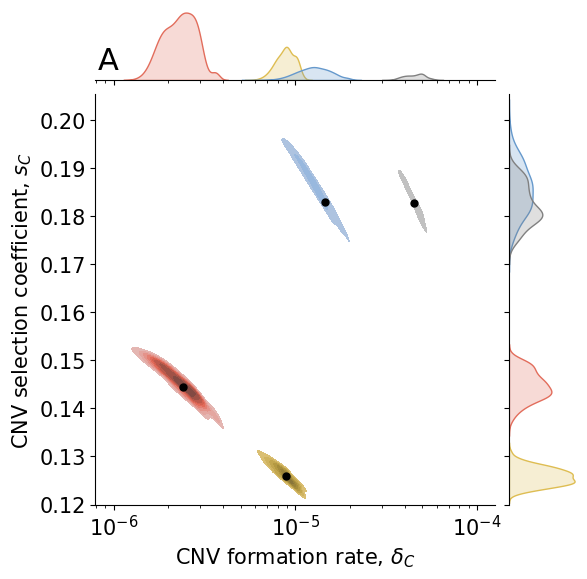

In [6]:
from seaborn import JointGrid, kdeplot, jointplot
import arviz as az
import matplotlib as mpl

label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = label_size

# Plot formation rate δc and fitness effect Sc for given MAPs
def plot_maps(lines):
    colors =  {'wt':"Greys", 'ltr':"Blues", 'ars': "Reds", 'all':"YlOrRd_r"}
    rep_colors = {'wt':"grey", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
    sample_df = pd.read_csv('maps/collective_posterior_samples.csv', index_col=0)
    maps = pd.read_csv('maps/collective_maps.csv', index_col=0)
    g = jointplot(data=sample_df, x=10**sample_df.loc[:,'$log_{10}(δ_C)$'], y=10**sample_df.loc[:,'$log_{10}(s_C)$'], hue='line', 
              palette=rep_colors, ax=ax, legend=False, kind='kde', fill=True, xlim=[10**-6.1, 10**-3.9],
                 )
    for line in lines: 
        mapp = np.array(maps[maps['line']==line].iloc[:,2:])[0]
        x, y = 10**mapp[1], 10**mapp[0]        
        g.ax_joint.scatter(x, y, color='k', s = 25) # plot MAP in black
        
    g.ax_joint.set_xlabel('CNV formation rate, $δ_C$')
    g.ax_joint.set_ylabel('CNV selection coefficient, $s_C$')
    g.ax_joint.set_xscale('log')
    g.figure.suptitle('A', fontsize=22, x=0.18, y=0.9)
    return g
        

lines = ['wt', 'ltr', 'ars', 'all']
g = plot_maps(lines)
# g.figure.savefig('hdis.png', dpi=800)

/tmp/ipykernel_2828446/1298614325.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_params = torch.tensor(collective_maps.loc[line, 'log(s_cnv)':]) # sbi params
/tmp/ipykernel_2828446/1298614325.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_params = torch.tensor(collective_maps.loc[line, 'log(s_cnv)':]) # sbi params
/tmp/ipykernel_2828446/1298614325.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  single_

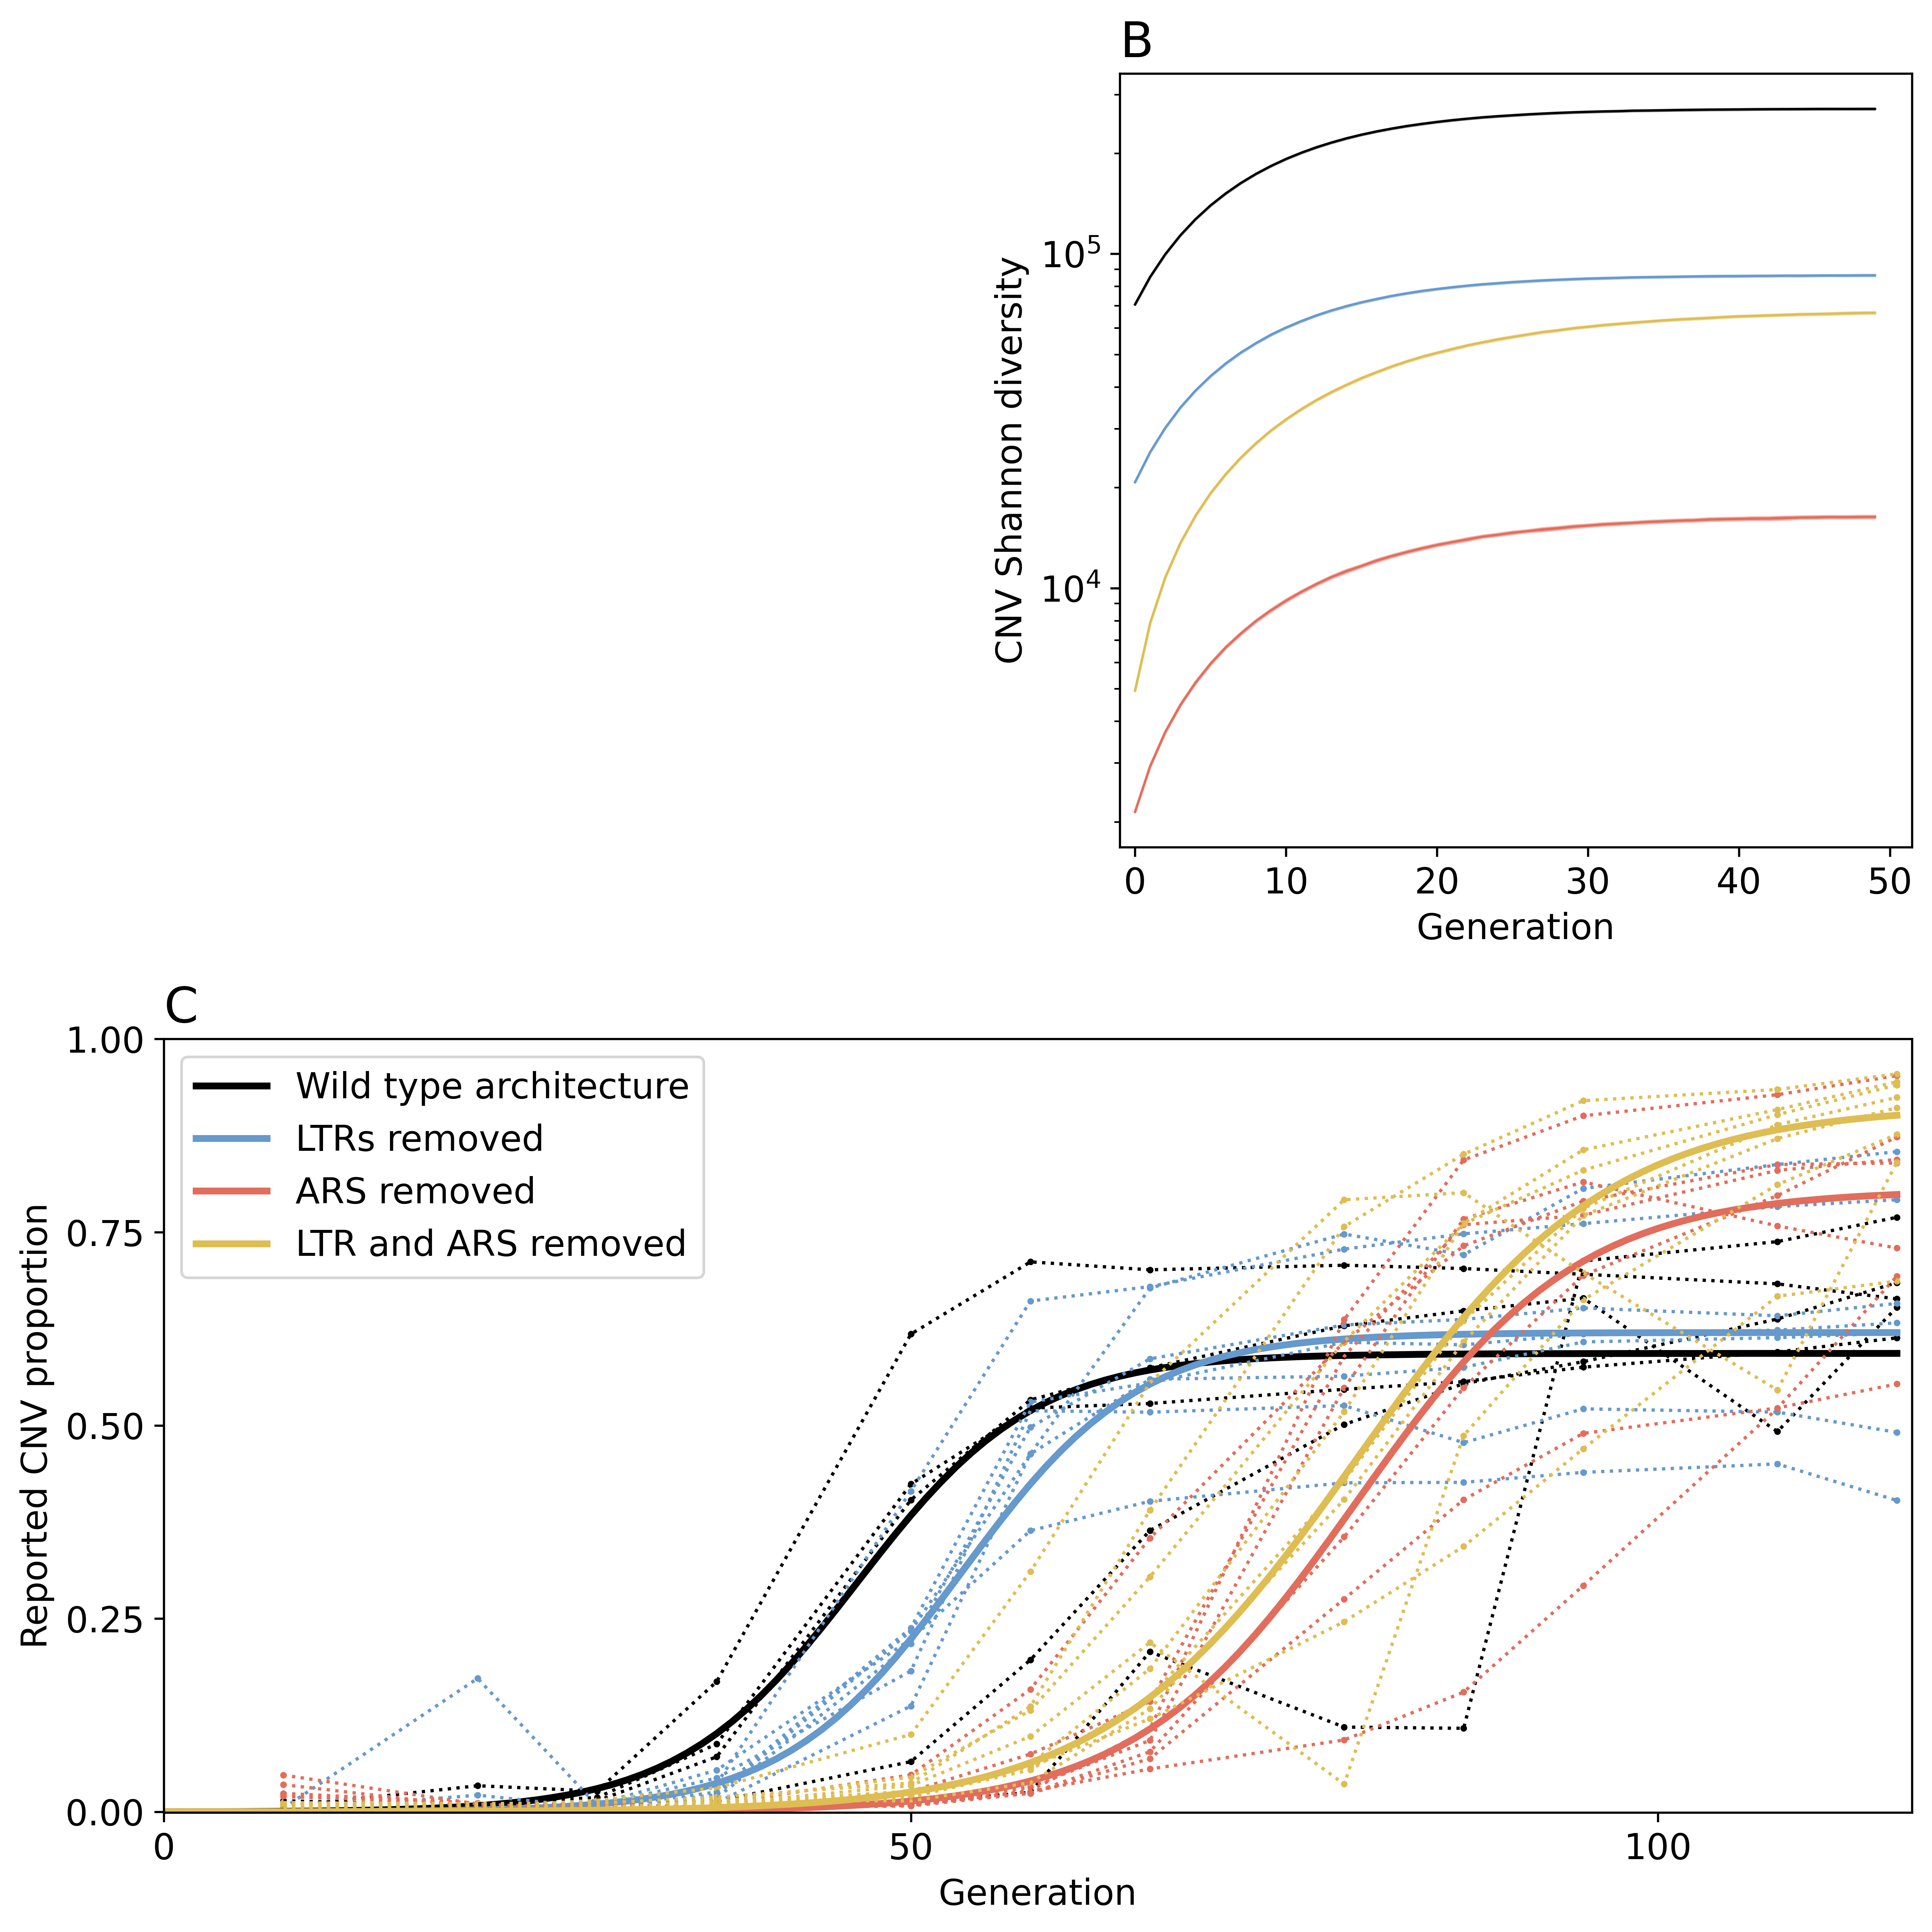

In [7]:
# B+C together
import matplotlib as mpl
label_size = 13
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = label_size

mosaic = '''AAAABBBB
            CCCCCCCC'''

fig, ax = plt.subplot_mosaic(mosaic, figsize=(10,10), tight_layout=True, dpi = 600)
ax['A'].axis('off')
ax['C'].set_xlim(0,117)
ax['B'].set_title('B', loc='left', fontsize=18)
ax['C'].set_title('C', loc='left', fontsize=18)
posterior_predictions_main(ax['C'],posterior_chuong,all_maps_sbi,lines=chuong_lines)
plot_all_shannons(ax['B'], chuong_lines)

mpl.rcParams["lines.linewidth"] = 0.00001 # No outline
# fig.savefig('main_sbi_figure.png')